In [ ]:
%pip install openai langchain PyPDF2 pypdf
%pip install -U langchain-community
%pip install python-dotenv

In [97]:
import os
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

## PDF 바탕으로 1차로 전처리 후 txt로 저장. 
## 그 txt 파일을 바탕으로 답변 생성

(정확도 증가)

### Full text를 다 넣어줬을 때 (카테고라이징 전)

In [ ]:
question = "원가계산체계정의 과정에서 원가계산단위를 어떻게 설정하나요?"

with open("preprocessed.txt", 'r', encoding='utf-8') as txt_file:
        pdf_text = txt_file.read()

prompt = f"""
질문: {question}

문서 내용:{pdf_text}

"""

response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "문서 내용을 참고해서 질문에 대해 답변해주세요."},
            {"role": "user", "content": prompt}
        ]
    )

print("답변: " + response.choices[0].message.content)

### 카테고라이징 후

문서 전처리

In [ ]:
import re

# 카테고리 생성 함수
def generate_categorized_txt(input_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    prompt = f"""
    # 목표
    - 문서의 주요 내용을 파악하여 논리적인 목차를 구성합니다.
    - 목차는 계층적으로 구성되며, 최대 2단계까지 세분화됩니다.
    - 일관된 포맷을 유지해야 합니다.

    # 출력 형식
    출력은 다음과 같은 형식을 따라야 합니다.
    1. [대주제] 1.1 [중주제]

    # 지침
    - 제목을 최대한 간결하게 작성합니다.
    - 중복되는 내용을 배제하고, 문서의 핵심 내용을 반영합니다.
    - 문서의 흐름을 고려하여 논리적인 순서로 정리합니다.

    # 입력
    다음은 분석할 Markdown 문서입니다:

    {content}

    # 출력 예시
    1. 원가계산체계정의
        1.1 원가계산기준
        1.2 원가구조 및 원가계정체계
        1.3 표준재고단가등록
        1.4 제품재투입단가등록/제품이동단가등록

    # 출력
    (여기에 목차를 출력)
    ...
    """

    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[ 
                {"role": "system", "content": "당신은 문서 분석을 전문으로 하는 AI입니다. 주어진 Markdown 파일의 내용을 기반으로 정확하고 논리적인 목차를 생성하세요."},
                {"role": "user", "content": prompt}
            ],
            temperature = 0.2
        )

    table_of_contents = response.choices[0].message.content

    output_file_path = "document/categorized.md"
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(table_of_contents)

    return table_of_contents

In [ ]:
input_file_path = "document/example.md"
generate_categorized_txt(input_file_path)

'```\n1. ERP-IU 소개\n    1.1 ERP-IU란?\n    1.2 시스템 운영환경\n    1.3 ERP-IU 기술 정보\n    1.4 ERP-IU 회계 메뉴 구성도\n    1.5 ERP-IU 기능 소개\n    1.6 ERP-IU Client 프로그램 설치\n    1.7 프로그램 작업순서\n\n2. 시스템 관리\n    2.1 시스템 현황정보\n        2.1.1 DD 관리\n        2.1.2 자료 IMPORT\n        2.1.3 다국어 입력\n    2.2 시스템 기준정보\n        2.2.1 코드관리\n        2.2.2 자동채번등록\n        2.2.3 통제환경설정관리\n        2.2.4 환율정보등록\n        2.2.5 리포트 관리 등록\n        2.2.6 시스템 환경설정\n        2.2.7 도움창 환경설정\n        2.2.8 회계환경설정\n    2.3 거래처 정보\n        2.3.1 거래처정보관리\n        2.3.2 거래처조회\n        2.3.3 거래처정보 변경내역\n    2.4 시스템 권한정보\n        2.4.1 그룹정보 등록\n        2.4.2 사용자정보 등록\n        2.4.3 권한관리\n        2.4.4 그룹메뉴 관리\n        2.4.5 사용자 메뉴관리\n        2.4.6 세부권한 환경설정\n        2.4.7 사용자별 세부권한\n        2.4.8 처리버튼 권한설정\n        2.4.9 환경설정 권한등록\n\n3. 회계기준정보\n    3.1 기초자료 등록\n        3.1.1 예적금계좌등록\n        3.1.2 신용카드등록\n        3.1.3 사업자등록번호\n        3.1.4 휴일정보등록\n    3.2 계정설정\n        3.2.1 계정등록\n        3.2.2 관리항목등록\n        3.2.3 관리내역등록\n        

In [ ]:
# 파일의 내용을 불러오는 함수
def load_data_from_file(filename):
    texts = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            text = line.strip()
            if text:
                texts.append(text)
    return texts

In [ ]:
categories = load_data_from_file("document/categorized.md")

def select_tag_from_category(categories):
    prompt = f"""

    # 목표
    - 목차의 최상위 레벨(1단계) 항목을 태그로 변환합니다.
    - 태그는 **반드시** 최상위 항목의 제목을 그대로 사용해야 합니다.
    - 태그는 str 형식으로 반환되어야 합니다.

    # 입력
    다음은 목차입니다:
    {categories}

    # 출력 형식
    - 태그는 반드시 아래 형식을 따라야 합니다.
    ["1. 최상위 항목1", "2. 최상위 항목2", "3. 최상위 항목3"]

    # 예시
    ## 입력
    카테고리:
    1. 대학교
        1.1 입학 준비
        1.2 학과 소개
    2. 중학교
        2.1 학생 지원
        2.2 교육과정
    3. 교육정책
        3.1 교육과정 개편
        3.2 교육과정 평가
    4. 입시제도
        4.1 입시제도 개편
        4.2 입시제도 평가
    
    ## 출력
    ["1. 대학교", "2. 중학교", "3. 교육정책", "4. 입시제도"]

    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "당신은 문서 분석을 전문으로 하는 AI입니다. 주어진 목차를 분석하여 최상위 항목을 기반으로 태그를 생성해야 합니다."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

tags = select_tag_from_category(categories)
print(tags)

["1. ERP-IU 소개", "2. 시스템 관리", "3. 회계기준정보", "4. 재무관리", "5. 건별 반제관리", "6. 외화관리", "7. 재무제표 관리", "8. 결산관리", "9. 손익관리", "10. 원가관리", "11. 배부관리"]


### 사용자 질문에서 관련 카테고리 추출

In [67]:
# 사용자가 질문을 입력하면 해당 카테고리 항목을 반환하는 함수
def select_category_for_question(question):

    prompt = f"""
    # 목표
    - 사용자의 질문을 분석하여 핵심 주제를 파악합니다.
    - 주어진 카테고리에서 질문과 가장 유사한 태그를 선택합니다.
    - 태그는 반드시 제공된 목록에서만 선택해야 하며, 필요 시 여러 개를 선택할 수 있습니다.
    - 선택된 태그는 일관된 형식을 따라야 합니다.

    # 입력
    사용자의 질문과 선택 가능한 카테고리 및 태그 목록이 주어집니다.

    질문: {question}
    
    카테고리: {categories}
    태그: {tags}
    
    # 출력 형식
    유사한 태그가 하나일 경우: ["1. 태그1"]
    유사한 태그가 여러 개일 경우: ["3. 태그3", "5. 태그5", "10. 태그10"]

    # 지침
    - 태그는 반드시 주어진 `태그 목록`에서만 선택해야 합니다.
    - 가장 관련성이 높은 태그를 1순위로, 필요 시 여러 개를 반환할 수 있습니다.
    - 태그의 순서는 중요하며, 가장 유사한 태그부터 나열하세요.

    # 출력
    아래 형식을 정확히 따르세요:
    ["1. 가장 유사한 태그"] ["2. 두 번째로 유사한 태그", "3. 세 번째로 유사한 태그"]

    # 예시
    ## 입력
    질문: "대학교 입학 준비는 어떻게 하면 좋을까요?"

    카테고리:
    1. 대학교
        1.1 입학 준비
        1.2 학과 소개
    2. 중학교
        2.1 학생 지원
        2.2 교육과정
    3. 교육정책
        3.1 교육과정 개편
        3.2 교육과정 평가
    4. 입시제도
        4.1 입시제도 개편
        4.2 입시제도 평가
    태그: ["1. 대학교", "2. 중학교", "3. 교육정책", "4. 입시제도"]

    ## 출력
    ["1. 대학교", "4. 입시제도"]

    """
    
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "당신은 사용자의 질문과 미리 정의된 카테고리를 비교하여 가장 적절한 태그를 선택하는 AI입니다. 반드시 제공된 태그 중에서만 선택해야 합니다."},
                {"role": "user", "content": prompt}
            ],
            temperature = 0.2
        )
    
    response_text = response.choices[0].message.content

    # 모델의 응답을 기반으로 해당 카테고리 항목을 반환
    return response_text

In [68]:
# 예시 질문
question = "SYS 코드가 ‘Y’로 표시된 것과 'N'으로 표시된 것의 차이점은 무엇인가요?"
category_answer = select_category_for_question(question)
print(category_answer)

["2. 시스템 관리", "3. 회계기준정보"]


In [85]:
import json, ast

def get_text_by_tags(json_file: str, selected_tags: list):

    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    selected_texts = {tag: data[tag] for tag in selected_tags if tag in data}

    return selected_texts

In [ ]:
json_file_path = "document/splitted.json"
category_list = ast.literal_eval(category_answer)
selected_tags_list = category_list

extracted_texts = get_text_by_tags(json_file_path, selected_tags_list)
    
for tag, text in extracted_texts.items():
    print(f"### {tag} ###\n{text}\n")

### 2. 시스템 관리 ###
1. 시스템 현황정보 1) DD 관리 [DD(Data Dictionary)관리]는 사용자가 수행하고자 하는 각각의 메뉴의 웹페이지명과 항목명을 사용자의 요구에 맞게 정의하는 관리메뉴이다.  모듈을 클릭하여 회계, 인사, 영업, 구매, 자재 등 원하는 모듈을 선택하고 검색란에 원 하는 메뉴, 이를 테면 ‘현금출납장’ 이라고 입력하고 (조회) 버튼을 클릭하면 현금출납장 이라는 명칭을 가진 DD 가 조회되며 명칭을 원하는 형태로 수정하고 (저장) 후 다시 로 그인하면 수정된 명칭으로 화면에 보여진다.  수정 전 명칭을 구분 코드란에 한글로 입력하고 한국어란에 수정 후 명칭을 입력한 뒤 (저장) 한 후 다시 로그인 하면 수정 후 명칭으로 조회된다.  [DD 관리]에는 출력물(장부/재무제표 및 각종 현황) 명칭도 포함하고 있으므로 해당 메 뉴에서 사용자가 원하는대로 출력물 명칭의 변경이 가능하다. 25 2) 자료 IMPORT [자료 IMPORT]는 전표, 세금계산서 등의 자료를 일괄로 업로드 하는 경우 사용하는 메뉴이다.  모듈을 클릭하여 회계, 인사, 영업, 구매, 자재 등 원하는 모듈을 선택하고 자료를 올릴 대상의 입력메뉴를 선택하여 (테이블내역보기) 버튼을 클릭한다. 26  <테이블 내역> 도움창이 화면에 활성화 되면 도움창 내의 오른쪽 상단 (서식 내려받기) 버튼을 클릭하여 엑셀 서식 파일을 PC 에 저장한다.  엑셀 파일로 테이블 내역이 받아지면 1 행에 영문 테이블명, 2 행에 한글 테이블명이 올 수 있도록 수정하고 3 행부터 해당 자료를 입력한다.  자료는 엑셀파일 내 Sheet1 위치에 저장되어야 자료를 올릴 수 있다.  엑셀 파일이 완성되면 [자료 IMPORT] 메뉴에서 (File 찾기) 버튼을 클릭 해당 파일을 불 러 온다.  화면의 자료를 확인 후 (저장) 버튼을 눌러 자료 IMPORT 작업을 마무리 한다.  화면에 불러와진 자료의 수정을 원할 경우 수정을 원하는 위치에 가서 자료를 수정 후 (저장)

### 최종 답변 생성

용어집 참여하고 답변

In [91]:
def load_glossary(glossary_file: str):

    with open(glossary_file, "r", encoding="utf-8") as f:
        glossary = json.load(f)
    return glossary

glossary_file = "glossary.json"
glossary = load_glossary(glossary_file)

In [92]:
def generate_answer(question, input_text, glossary):
    prompt = f"""
    # 목표
    - 사용자 질문을 분석하여 핵심 정보를 파악합니다.
    - 제공된 문서에서 관련 내용을 찾아 정확한 답변을 제공합니다.
    - 문서에 해당 내용이 없을 경우, "제공된 문서에는 해당 정보가 없습니다."라고 응답하세요.
    - 전문 용어가 필요할 경우, 제공된 용어집을 참고하여 적절한 용어를 사용하세요.
    - 응답 형식은 간결하지만, 필요하면 세부적인 정보를 포함해야 합니다.

    # 제약 사항
    - 문서에 있는 정보만 사용하여 답변하세요.
    - 불확실한 정보는 생성하지 마세요.
    - 질문과 직접적으로 관련된 문서 내용을 인용하여 답변을 작성하세요.

    # 용어집
    아래는 전문 용어의 정의입니다.  
    필요할 경우 적절한 용어를 사용하여 답변을 작성하세요.
    {glossary}

    # 입력 문서
    다음은 사용자가 제공한 문서 내용입니다.
    {input_text}

    # 사용자의 질문 
    {question}
    
    """
    
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "당신은 사용자가 제공한 문서를 기반으로 질문에 답하는 AI 비서입니다. 답변을 작성할 때 반드시 주어진 문서의 내용을 바탕으로 하며, 문서에 없는 정보는 절대 생성하지 마십시오. 또한, 전문 용어가 필요할 경우 제공된 용어집을 참고하여 정확한 용어를 사용하십시오"},
                {"role": "user", "content": prompt}
            ],
            temperature = 0.2 
        )
    
    response_text = response.choices[0].message.content
    print(response_text)

    # 모델의 응답을 기반으로 해당 카테고리 항목을 반환
    return response_text

In [93]:
final_answer = generate_answer(question, extracted_texts, glossary)

제공된 문서에 따르면, SYS 코드가 ‘Y’로 표시된 것은 사용자가 수정하거나 추가할 수 없는 코드로, ERP 시스템의 일관성을 유지하기 위해 변경이 제한됩니다. 반면, SYS 코드가 'N'으로 표시된 것은 사용자가 사용 코드를 추가할 수 있는 코드입니다. 즉, 'Y'는 수정 불가능한 코드, 'N'은 수정 및 추가가 가능한 코드입니다.


## 멀티 모달

In [ ]:
pip install matplotlib


In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
png_images = load_data_from_file("image_tag.txt")

# 사용자가 질문을 입력하면 해당 카테고리 항목을 반환하는 함수
def select_image(question):

    prompt = f"""
    질문: {question}
    카테고리: {png_images}
    
    답변 가능 형식: 
    그림2. 원가계산체계정의 프로세스
    
    #, '', 와 같은 특수문자는 절대 포함하지 마세요.
    """
    
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "주어진 질문과 유사한 그림이 있다면, 카테고리에서 하나 선택하세요. 없으면 None을 반환하세요."},
                {"role": "user", "content": prompt}
            ]
        )
    
    response_text = response.choices[0].message.content
    print(response_text)

    # 모델의 응답을 기반으로 해당 카테고리 항목을 반환
    return response_text


그림2. 원가계산체계정의 프로세스


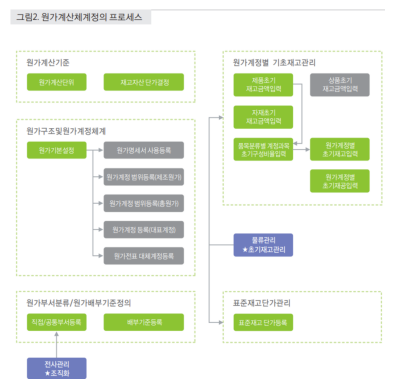

In [20]:
image = select_image(question)
if image != None:
    img = mpimg.imread('pic/' + image + '.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# 결론

### 데이터 전처리 과정 통해 문서 형식 일정하게 해놓으면 성능 좋다!